# 0. Introduction

We are going to use the data that we have been provided to study and try to predict the evolution of Dengue disease in the cities of **San Juan**, *Puerto Rico*, and **Iquitos**, *Peru*. More information in this [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/).

Before starting to make our first models, it is important to know the data set that we have well, to know what we are working with, and in this way, to be able to draw conclusions that help us when carrying out the models and thinking improvements for these.

Therefore, in this notebook, we are going to investigate above all the variables that make up our data set. For this, we will see the importance that some of them could have when the Dengue mosquito spreads the disease.

# 1. Libraries

Before starting any analysis we must make sure that the libraries we are going to use are imported correctly.

In [ ]:
# Preprocessing
from sklearn import preprocessing

# Loading the data
import pandas as pd
import io
from google.colab import files

# Visualization 
import seaborn as sns

# Others
import warnings
warnings.filterwarnings('ignore') # When drawing graphs, warnings sometimes appear, they don't interest us.

# 2. Loading the data 

The first obviously is to load the data, in this notebook we will need to load the data that will be used as training in the models, and their labels. In such a way that you must have the *dengue_features_train.csv* and *dengue_labels_train.csv* files loaded in this notebook

## Loading the datasets

In [ ]:
# Load data and set index to city, year, weekofyear
df = pd.read_csv('./dengue_features_train.csv')

# Fill missing values
df.fillna(df.mean(), inplace=True)
lb = preprocessing.LabelBinarizer()

# Load the labels
labels = pd.read_csv('./dengue_labels_train.csv')

In [ ]:
# Show training data
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
# Show total case data by week
labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


## Merge the datasets

In order to better study these data, we merge both data sets into one. They can be joined thanks to the *city*, *year* and *weekofyear* attributes.

In [ ]:
df_train = pd.merge(labels, df, on=['city','year','weekofyear'])
df_train.head()

,city,year,weekofyear,total_cases,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,4,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,6,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


# 3. Exploring the data

Now that we have an optimal data set to start working on and get conclusions about the data, we proceed to explore this data.

## Correlation between variables

We are going to study the correlation between the variables that can influence the spread of dengue.

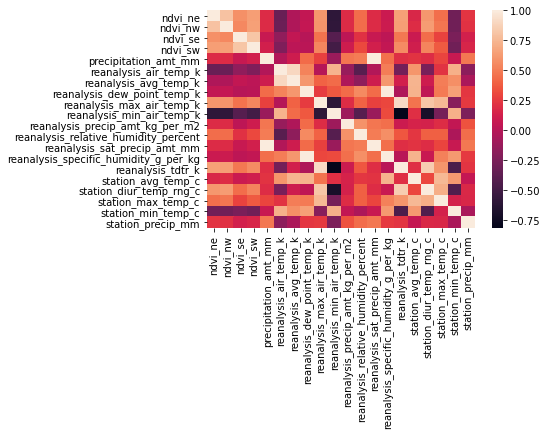

In [ ]:
# We eliminate columns that don't influence the spread of dengue.
df_correlation = df
df_correlation.drop(['city', 'year','weekofyear'], axis = 'columns', inplace=True) 

# Plot the correlation
mtx_corr = df_correlation.corr()
sns.heatmap(mtx_corr, xticklabels=mtx_corr.columns, yticklabels=mtx_corr.columns, annot=False)

As our dataset has many features, it is very difficult to draw important conclusions in the correlation matrix. The only remarkable thing is that the different features that are related to similar aspects, such as humidity, air, and others, are usually more or less correlated.

## Study of the evolution of the disease in each city

Now we are going to represent the total number of cases by cities in a histogram, which represents the distribution of this variable in both cities.

(0.0, 0.09)

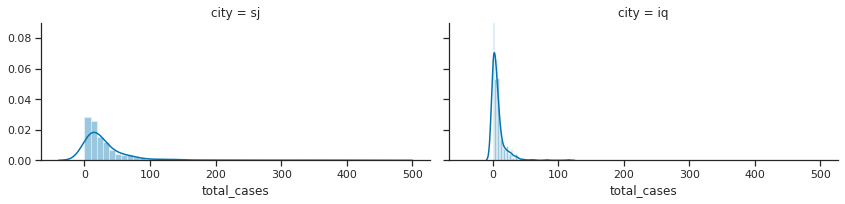

In [ ]:
sns.set(style="ticks", palette="colorblind")
g = sns.FacetGrid(df_train, col= "city", aspect = 2)  
g.map(sns.distplot, "total_cases") 
axes = g.axes
axes[0,0].set_ylim(0, 0.090)
axes[0,1].set_ylim(0, 0.090)

Right now, we might think that these graphs represent that Iquitos in our data set has a total number of cases higher than that of San Juan, let's check it!

To do this, we will use the *group_by* function, which will help us to group the records of our dataset by city.

In [ ]:
df_train.groupby('city').sum().total_cases

city
iq     3934
sj    31993
Name: total_cases, dtype: int64

And... Surprise! Our thinking wasn't correct. In our data set there are many more cases of dengue detected in San Juan than in Iquitos.

We are now going to represent the evolution of the disease in the two cities.

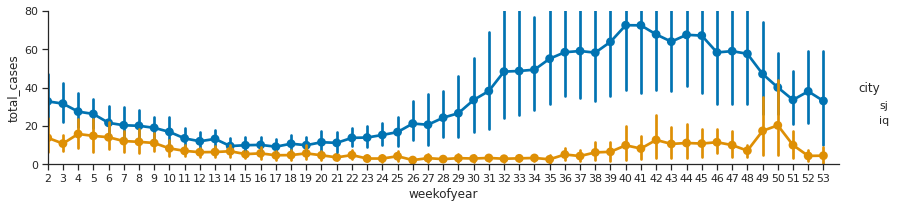

In [ ]:
sns.set(style="ticks", palette="colorblind")
fig = sns.FacetGrid(df_train, hue='city', aspect=4) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = df_train.weekofyear.max()
min_x = df_train.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 80))
fig.add_legend()
#fig.fig.suptitle("Evolution of dengue disease through time")

As a main conclusion, we can confirm that in the city of San Juan, the disease spreads more in the second half of the year. While in Iquitos, fewer cases are registered throughout the year, and the new cases detected decrease little by little from the beginning of the year to the end of the year, where there is an increase in cases.

## Looking for the most decisive variables


At this point, after viewing the correlation matrix and study the evolution of the disease by city, it will be important to define what are the aspects that could be very definitive when it comes to spreading dengue.

Looking for information in [papers](http://www.scielo.org.co/pdf/cesm/v33n1/0120-8705-cesm-33-01-42.pdf) on which aspects are the ones that most influence the spread of dengue, we have found that the fundamental aspects are humidity and temperature, therefore it would be interesting to think about using features related to these two aspects for our models.

The mosquito that spreads this disease usually lives in places with a hot and humid climate.

We are going to draw which are the variables that have a greater correlation with the variable of the total of cases, this graph will help us a lot to make the decision of selection of variables with which we will make our models.

In [ ]:
df_train.corr()['total_cases']

year                                    -0.306806
weekofyear                               0.216452
total_cases                              1.000000
ndvi_ne                                 -0.157320
ndvi_nw                                 -0.137254
ndvi_se                                 -0.117769
ndvi_sw                                 -0.137221
precipitation_amt_mm                    -0.038670
reanalysis_air_temp_k                    0.264564
reanalysis_avg_temp_k                    0.151415
reanalysis_dew_point_temp_k              0.142322
reanalysis_max_air_temp_k               -0.191066
reanalysis_min_air_temp_k                0.324776
reanalysis_precip_amt_kg_per_m2         -0.010016
reanalysis_relative_humidity_percent    -0.132259
reanalysis_sat_precip_amt_mm            -0.038670
reanalysis_specific_humidity_g_per_kg    0.129671
reanalysis_tdtr_k                       -0.278076
station_avg_temp_c                       0.115478
station_diur_temp_rng_c                 -0.236552


Therefore, now and we have the theoretical explanation that factors influence the expansion of dengue, and the correlation of the features of our data set with the total number of cases, therefore, we can now select which variables we will work with.

## Choice of variables and their correlation

The variables with which we are going to choose to work from now on based on the results obtained previously are:

- **reanalysis_dew_point_temp_k:** mean dew point temperature
- **reanalysis_specific_humidity_g_per_kg:** mean specific humidity
- **station_avg_temp_c:** average ambient temperature
- **station_min_temp_c:** minimum ambient temperature

We are going to study their correlation.

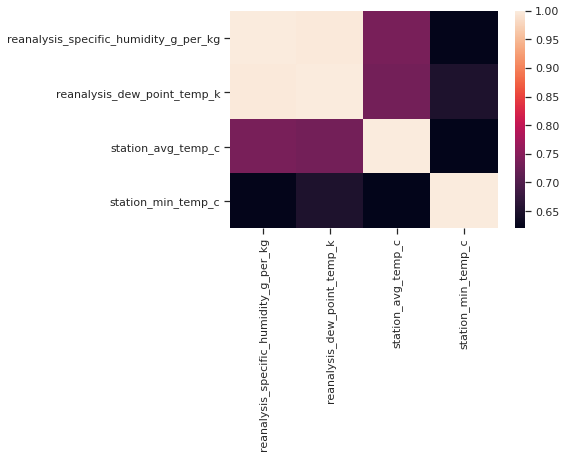

In [ ]:
# Select the features
df_selected = pd.DataFrame()
df_selected['reanalysis_specific_humidity_g_per_kg'] = df['reanalysis_specific_humidity_g_per_kg']
df_selected['reanalysis_dew_point_temp_k'] = df['reanalysis_dew_point_temp_k']
df_selected['station_avg_temp_c'] = df['station_avg_temp_c']
df_selected['station_min_temp_c'] = df['station_min_temp_c']

# Plot the correlation
mtx_corr = df_selected.corr()
sns.heatmap(mtx_corr, xticklabels=mtx_corr.columns, yticklabels=mtx_corr.columns, annot=False)